## Generating Dataset
Let's create the toy dataset. We'll have a 1 16x16 image with a 4x4 square placed somewhere inside.

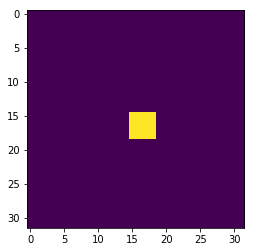

In [1]:
import chainer
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook

def get_random_image():
    # Returns random image along with its ground truth
    img = np.zeros((1,3,32,32), dtype=np.float32)
    
    gts = []
    
    for i in range(1):
        # Choose random coordinate, this can also be run in a loop
        width = 4
        height = 4
        pos_r = np.random.randint(0, img.shape[2]-height-1)
        pos_c = np.random.randint(0, img.shape[3]-width-1)
        img[0,:,pos_r:pos_r+height,pos_c:pos_c+width]=1
        #print(pos_r, pos_c)

        cx = pos_c + width/2.0
        cy = pos_r + height/2.0
        
        box = [cx, cy, width, height, 1, 0]
        
        gts.append(box)
    
    # Create ground truth object
    gt = chainer.Variable(np.array(gts, dtype=np.float32))
    return img, gt

#------------------------------------------------------------

img = np.zeros((1,3,32,32), dtype=np.float32)
    
gts = []

for i in range(1):
    # Choose random coordinate, this can also be run in a loop
    width = 4
    height = 4
    pos_r = 15
    pos_c = 15
    img[0,:,pos_r:pos_r+height,pos_c:pos_c+width]=1
    #print(pos_r, pos_c)

    cx = pos_c + width/2.0
    cy = pos_r + height/2.0

    box = [cx, cy, width, height, 1, 0]

    gts.append(box)

# Create ground truth object
gt = chainer.Variable(np.array(gts, dtype=np.float32))

#_------------------------------------------------------------




for i in range(1):
    # Initialize the image
#     img, gt = get_random_image()
    
    # Visualize the entire thing
    plt.imshow(img[0,0,:,:])
    plt.show()

## Generating Feature maps
Now that we have the image, we'll go over it one by one and generate feature maps of size 4x4.

In [2]:
from chainer import Chain
import chainer
import chainer.functions as F
import chainer.links as L

class ConvNet(Chain):
    def __init__(self):
        super(ConvNet, self).__init__(
            l1=L.Convolution2D(None,32,ksize=(3,3),stride=1,pad=1),
            l2=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),
            l3=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1)
        )
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.max_pooling_2d(h1, 2)
        h3 = F.relu(self.l2(h2))
#         h4 = F.max_pooling_2d(h3, 2)
#         h5 = F.relu(self.l3(h4))
#         h6 = F.max_pooling_2d(h5, 2)
        return self.l3(F.sigmoid(h3))

## Linear Convolution to generate shifts

In [3]:
class BoxNet(Chain):
    def __init__(self, predictor):
        super(BoxNet, self).__init__(
            l1=L.Convolution2D(None,6,ksize=(3,3),stride=1,pad=1)
        )
        self.predictor = predictor
        
    def __call__(self, x):
        h1 = self.l1(self.predictor(x))
        return h1
    
convnet = ConvNet()
boxnet = BoxNet(ConvNet())
fm = convnet(img)
shifts = boxnet(img)
fm.shape
shifts= shifts[:,:,8,8]
shifts =F.reshape(shifts,[1,6,1,1])
shifts.shape

(1, 6, 1, 1)

## Draw generated default boxes on top of the original image

In [4]:
from matplotlib import patches
import random 
def defaultgen(I, F, width, height):
    """
    Generates an array of default boxes: Chainer TESTED
    
    Args:
        I: Input image tensor (N,channels,rows,cols)
        F: Feature map tensor to generate default boxes for
        width: Width of the box
        height: Height of the box
        
    Returns:
        db: Default boxes tensor, flattened
    """
    scale = (I.shape[2] / F.shape[2])
    offset = np.ones((2,F.shape[2],F.shape[3]), dtype=np.float32)
    iterator = np.flip(np.indices((F.shape[2],F.shape[3])), axis=0).astype(np.float32)
    
    xys = offset * ((scale-1)/2) + iterator * scale
    xys = np.moveaxis(xys,0,2)
    ws = np.full((F.shape[2],F.shape[3],1), width, dtype=np.float32)
    hs = np.full((F.shape[2],F.shape[3],1), height,dtype=np.float32)
    class_scores = np.zeros((F.shape[2],F.shape[3],2), dtype=np.float32)
    db = np.dstack([xys, ws, hs, class_scores])
   
    db = db[8,8,:]
    db = db.reshape([1,1,6])
    
    return chainer.Variable(db.reshape((db.shape[0] * db.shape[1], 6)))

def center_to_coords(box):
    """ 
    Converts bounding box from (cx, cy, w, h) format to (x1, y1, x2, y2) format
    
    Args:
        box: 6d numpy array
        
    Returns:
        box_transformed: Box in the second format
    
    """
    box_transformed = np.array([box[0]-box[2]/2.0, box[1]-box[3]/2.0, box[0]+box[2]/2.0, box[1]+box[3]/2.0, box[4], box[5]])
    return box_transformed


def draw_boxes(img, boxes):
    plt.figure()
    ax = plt.axes()

    for box in boxes:
        box = center_to_coords(box.data)
        ax.imshow(img[0,0,:,:])
        p = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color = 'red')
        ax.add_patch(p)

    plt.show()

# def_boxes = defaultgen(img, fm, 10,10)
# def_boxes[0][2:4]
# draw_boxes(img, def_boxes)
# def_boxes.dtype


### This tiling is really bad. Most of the default boxes will not overlap!
* We need lot more boxes.
* We need a large enough receptive field.

## Draw predictions on top of the original image
Now with the shift tensor we have obtained from running convnet and boxnet together, let's offset the default boxes.

In [6]:
def get_pred_boxes(shift_vals, default_boxes ): 
    """
    Get predicted boxes by combining shift values to default boxes
    Input: 

    shift_values : Shifts generated by the network  NDarray (None, Num of Default boxes, 4+num of classes)
    Default boxes  : Default boxes generated by the network NDarray (None, Num of Default boxes, 4+num of classes)

    Output: 

    Predicted boxes  : Predicted boxes, same shape as default boxes  NDarray (None, Num of Default boxes, 4+num of classes)

    """
    
    shift_val_shape= default_boxes.shape
    shift_vals= F.swapaxes(shift_vals,1,3)
    shift_vals= F.reshape(shift_vals,shift_val_shape)
    shifts = shift_vals 
    def_boxes= default_boxes
    
    
    cx_pred = (shifts[:,0]*shifts[:,2])+def_boxes[:,0]
    cy_pred = (shifts[:,1]*shifts[:,2])+def_boxes[:,1]
    
    H_pred = F.exp(shifts[:,2])*def_boxes[:,2]
    W_pred = F.exp(shifts[:,3])*def_boxes[:,3]
    
    class1 = shifts[:,4]
    class2 = shifts[:,5]
    
    
    pred_boxes = F.vstack((cx_pred,cy_pred,W_pred,H_pred, class1, class2))
    pred_boxes = F.transpose(pred_boxes)
    
    return  pred_boxes 


def draw_pred_boxes(prediction_boxes, default_boxes): 
    """Draw predicted boxes on the original image """
    
    pred_boxes= prediction_boxes
    def_boxes =default_boxes.data
    pred_boxes = get_pred_boxes(shifts, def_boxes)
     
    boxes = pred_boxes.data
    
    plt.figure()
    ax = plt.axes()

    for i in range(def_boxes.shape[0]):
        box = def_boxes[i]
        box2 =boxes[i]            
        box = center_to_coords(box)
        box2 = center_to_coords(box2)            
        ax.imshow(img[0,0,:,:])

        default_boxes = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color = 'red')
        pred_boxes = patches.Rectangle((box2[0], box2[1]), box2[2]-box2[0], box2[3]-box2[1], fill=False, color = 'yellow')

        ax.add_patch(default_boxes)
        ax.add_patch(pred_boxes)


    plt.show()
#     plt.savefig('shifts')





#pred_boxes = get_pred_boxes(shifts, def_boxes)
#draw_pred_boxes(pred_boxes, def_boxes)



In [7]:
pred_boxes.shape, def_boxes.shape

NameError: name 'pred_boxes' is not defined

## Do matching

In [8]:
# Let's define some useful functions first.
# Work with chainer variables for instahook.
#from chainer.functions import max, min, hstack

def iou_cpu(boxA, boxB):
    """
    Calculates intersection over union score of two rectangles, none of them rotated.: TESTED
    
    Args:
        boxA: Box1
        boxB: Box2
        
    Returns:
        iou (scalar): IOU score of the two boxes
    """
        # determine the (x, y)-coordinates of the intersection rectangle
        # Maybe we can accelerate this by writing this as a cython extension
        
    boxA = center_to_coords(boxA)
    boxB = center_to_coords(boxB)
    
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max((xB - xA), 0) * max((yB - yA), 0)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxa_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxb_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    #print(interArea, boxa_area, boxb_area)
    iou = interArea / (boxa_area + boxb_area - interArea)

    # return the intersection over union value
    return iou

def find_match_indices_cpu(pred_boxes, gt): 
    """
    Find matches between ground truth boxes and boxes predicted by network.
    
    Args:
        gt (): Tensor of ground truth boxes
        pred_boxes (): Tensor of predicted boxes
        
    Returns:
        pos_inds: Indices of the connectivity matrix where there is a positive match
        neg_inds: Indices of the connectivity matrix where there is a negative match
    """
    
    pos_iou_score =  np.zeros((gt.shape[0], pred_boxes.shape[0]), dtype=np.float32)
    neg_iou_score = np.ones((gt.shape[0], pred_boxes.shape[0]), dtype=np.float32)
    
    thresh = 0.0
    
    for i in range(gt.shape[0]): 
        for j in range(pred_boxes.shape[0]): 
            iou_score  = iou_cpu(gt[i].data, pred_boxes[j].data)
            
            if iou_score > thresh:  
                pos_iou_score[i,j] = iou_score
            else :
                neg_iou_score[i,j] = iou_score
    
    pos_inds  = np.argwhere(pos_iou_score>thresh)
    neg_inds = np.argwhere(neg_iou_score<=thresh)
    neg_val_indices = np.where(neg_iou_score<=thresh)
    neg_values = np.array([neg_val_indices[0], 
                           neg_val_indices[1],
                           neg_iou_score[np.where(neg_iou_score<=thresh)]])


    neg_values = neg_values.transpose()
    neg_values= np.flipud(neg_values[neg_values[:,2].argsort()])
    number_of_neg_examples  = len(pos_inds)*3 
    neg_values = neg_values[0:number_of_neg_examples,: ]   
    neg_inds = tuple(neg_inds)

    return  pos_inds, neg_inds, pos_iou_score, neg_iou_score

In [9]:
# pos_inds, neg_inds, pos_iou_score, neg_iou_score = find_match_indices_cpu( pred_boxes, gt)
# pos_inds
# pos_iou_score

Ok let's try some examples now and see if it works. Copy pasting some unit tests from before.

In [10]:
# # In the default network, these variables will be parameterized
# gt_test = chainer.Variable(np.array([[0.5,0.5,3,3,0,0]], dtype=np.float32))
# pred_boxes_test = chainer.Variable(np.array([[0,0,4,2,0,0], [2.5,2.5,3,3,0,0], [12.5,2.5,3,3,0,0]], dtype=np.float32))
# #def_boxes = chainer.Variable(np.array([[0,0,4,2,0,0], [2.5,2.5,3,3,0,0], [12.5,2.5,3,3,0,0]], dtype=np.float32))

# iou_cpu(gt_test[0].data, pred_boxes_test[1].data)
# pos_inds, neg_inds, pos_score, neg_score = find_match_indices_cpu(pred_boxes_test, gt_test)

# #pos_inds
# np.testing.assert_almost_equal(iou_cpu(gt_test[0].data, pred_boxes_test[0].data), 0.54, 1,'IOU calculation not working')
# np.testing.assert_array_equal(pos_inds[0], [0, 0], 'Posititve matching not working')
# #np.testing.assert_array_equal(neg_inds[0], [0, 1], 'Negative matching not working')
# #np.testing.assert_array_equal(neg_inds[1], [0, 2], 'Positive matching not working')

# print('Everything works')
# #box1 = gt[0]
# #box2 = pred_boxes[0]

Ok/

## Compute regression loss from indices (brute force for loop cpu)
* Run for loop over all the positive indices.
* Calculate relative shift vector for ground truth.
* Regress for relative shift vector with prediction shift vector.

In [11]:
from chainer.functions import log, hstack, huber_loss

def normalize_shift(box, def_box):
    """
    Scales down absolute shifts, % for centers, log for height and width.
    
    Args:
        box: 6x1 bounding box coordinates
        def_box: 6x1 reference box coordinates
        
    Returns:
        normalized_shift_vector: 4x1 normalized shift vector. Note that we discard the last 2 channels.
    """
    tx = (box[0] - def_box[0])/def_box[2]
    ty = (box[1] - def_box[1])/def_box[3]
    tw = log(box[2]/def_box[2])
    th = log(box[3]/def_box[3])
    
    return hstack([tx, ty, tw, th])
    

def regression_loss(pred_box, gt_box, def_box):
    """
    Calculates regression loss between two boxes w.r.t a reference default box.
    
    Args:
        pred_box: 6x1 bounding box predicted by the network
        gt_box: 6x1 bounding box overlapping with pred_box
        def_box: 6x1 bounding box with same index as pred_box
        
    Returns:
        reg_loss: Scalar of huber loss between two vectors
    """
    print(pred_box.shape, gt_box.shape)
    %pdb
    ydiff = pred_box[1] - gt_box[1]
    
    return ydiff.reshape(1)
    
    #pred_shift = normalize_shift(pred_box, def_box).reshape((1, 4))
    #gt_shift = normalize_shift(gt_box, def_box).reshape((1, 4))
    
    #return huber_loss(pred_shift, gt_shift, delta=0.5)

So let's try it for the boxes above and see if it actually works.

Awesome. No bugs. Still have to check it for logical consistency though. Moving on to implement classification loss

## Compute classification loss from indices (brute force for loop cpu). All DONE!

In [12]:
from chainer.functions import softmax, log, matmul

def soft_max(x): 
    
    x = x.reshape([1,2])
    soft_score  = F.softmax(x)
    #soft_score =soft_score.reshape([2])
    return soft_score

def classification_loss(pred_box, gt_box, switch):
    """
    Calculates classification loss between two predicted and true box.
    
    Args:
        pred_box: 6x1 box, last two are classification scores
        gt_box: 6x1 box, last two are classification scores
        switch: Positive or negative indicator
        
    Returns:
        loss: Scalar positive or negative cross entropy loss. Only one is active at a time.
    """
    pred_prob = soft_max(pred_box[4:6])
    gt_prob =soft_max(gt_box[4:6])
    
    pos_loss = -matmul(gt_prob, log(pred_prob).transpose())
    neg_loss = -matmul(gt_prob, log(1.0 - pred_prob).transpose())
    
    loss = switch * pos_loss + (1 - switch) * neg_loss
    return loss.reshape(1)
    
#cl1 = classification_loss(pred_boxes[0], gt[0], 1.0)    



In [13]:
def compute_loss(gt_boxes, pred_boxes, def_boxes, pos_inds, neg_inds):
    loss_class = chainer.Variable(np.array([0.], dtype=np.float32))
    loss_reg = chainer.Variable(np.array([0.], dtype=np.float32))
    
    for i, j in pos_inds:
        gt_box, pred_box, def_box = gt_boxes[i], pred_boxes[j], def_boxes[j]
        
        loss_reg += regression_loss(pred_box, gt_box, def_box)
        #loss_class += classification_loss(pred_box, gt_box, 1)
        
    for i, j in neg_inds:
        gt_box, pred_box, def_box = gt_boxes[i], pred_boxes[j], def_boxes[j]
        
        #loss_class += classification_loss(pred_box, gt_box, 0)
        
    if loss_reg.data<0:
        return -1*loss_reg
    
    
    else:       
        return loss_reg# + loss_class # Can also do lambda weighting here
        

## Functional connectivity?

  0%|          | 0/10 [00:00<?, ?it/s]

variable([ 15.97893715  16.601614     7.00828552   6.55624485   0.35080093
            0.57815111])
1
(6,) (6,)
Automatic pdb calling has been turned ON


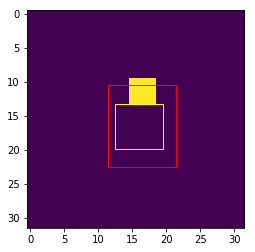

 10%|█         | 1/10 [00:00<00:01,  6.37it/s]

variable([ 16.23723412  16.47310066   7.00828552   8.08241653   0.35080093
            0.57815111])
1
(6,) (6,)
Automatic pdb calling has been turned OFF


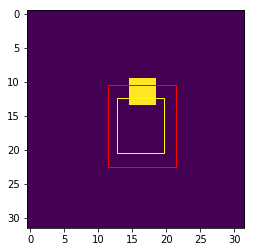

 20%|██        | 2/10 [00:00<00:01,  6.16it/s]

variable([ 16.10164261  16.39947891   7.00828552   7.24154234   0.35080093
            0.57815111])
1
(6,) (6,)
Automatic pdb calling has been turned ON


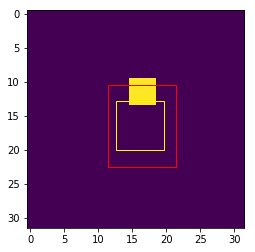

 30%|███       | 3/10 [00:00<00:01,  6.52it/s]

variable([ 15.76741695  16.14858437   7.00828552   5.52368069   0.35080093
            0.57815111])
1
(6,) (6,)
Automatic pdb calling has been turned OFF


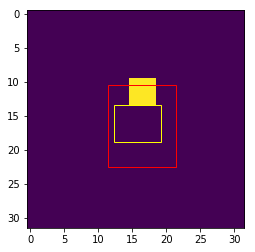

 40%|████      | 4/10 [00:00<00:00,  6.52it/s]

variable([ 15.13206196  15.2718668    7.00828552   3.30117178   0.35080093
            0.57815111])
1
(6,) (6,)
Automatic pdb calling has been turned ON


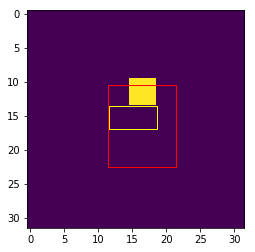

 50%|█████     | 5/10 [00:00<00:00,  6.64it/s]

variable([ 13.9429245   12.20790291   7.00828552   1.25965106   0.35080093
            0.57815111])
1
(6,) (6,)
Automatic pdb calling has been turned OFF


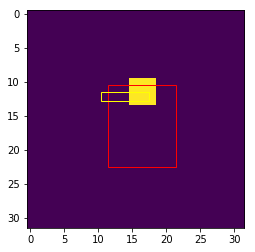

 60%|██████    | 6/10 [00:00<00:00,  6.66it/s]

variable([ 11.71972084   1.49991322   7.00828552   0.20795964   0.35080093
            0.57815111])
0


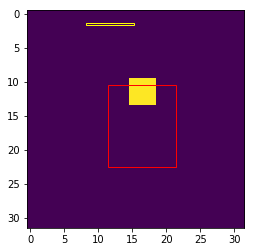

 70%|███████   | 7/10 [00:01<00:00,  6.60it/s]

variable([ 11.71972084   1.49991322   7.00828552   0.20795964   0.35080093
            0.57815111])
0


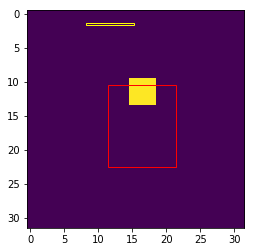

 80%|████████  | 8/10 [00:01<00:00,  6.90it/s]

variable([ 11.71972084   1.49991322   7.00828552   0.20795964   0.35080093
            0.57815111])
0


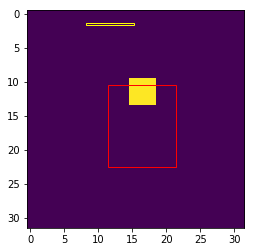

 90%|█████████ | 9/10 [00:01<00:00,  7.34it/s]

variable([ 11.71972084   1.49991322   7.00828552   0.20795964   0.35080093
            0.57815111])
0


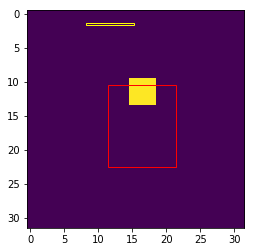

100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


In [14]:
from chainer.optimizers import SGD
from tqdm import tqdm

boxnet = BoxNet(ConvNet())
#boxnet(img)

optimizer = SGD()
optimizer.setup(boxnet)

loss_history = []

for i in tqdm(range(10)):
    # Verifying the image nad ground truth size
#     img, gt = get_random_image()

    img = np.zeros((1,3,32,32), dtype=np.float32)
    
    gts = []
    
    for i in range(1):
        # Choose random coordinate, this can also be run in a loop
        width = 4
        height = 4
        pos_r = 10
        pos_c = 15
        img[0,:,pos_r:pos_r+height,pos_c:pos_c+width]=1
        #print(pos_r, pos_c)

        cx = pos_c + width/2.0
        cy = pos_r + height/2.0
        
        box = [cx, cy, width, height, 1, 0]
        
        gts.append(box)
    
    # Create ground truth object
    gt = chainer.Variable(np.array(gts, dtype=np.float32))
    
    
    
    
    
    
    
    
    # Initializing the network and computing the features and shifts
    #fm = convnet(img)
    shifts = boxnet(img)
    shifts= shifts[:,:,8,8]
    shifts =F.reshape(shifts,[1,6,1,1])
    
    #shifts.shape

    # Getting default_boxes and predictions
    # Forward pass ends here
    def_boxes = defaultgen(img, fm, 10,12)
    
    pred_boxes = get_pred_boxes(shifts, def_boxes)

    def_boxes.shape, pred_boxes.shape
    print(pred_boxes[0])

    # Matching step
    pos_inds, neg_inds, pos_score, neg_score = find_match_indices_cpu(pred_boxes, gt)
    print(len(pos_inds))
    # Computing the loss
    boxnet.zerograds()
    loss = compute_loss(gt, pred_boxes, def_boxes, pos_inds, neg_inds)
    
    if i % 10 == 0:
        draw_pred_boxes(pred_boxes, def_boxes)
    
    #print(loss)
    loss_history.append(loss.data[0])
    loss.backward()
    
    optimizer.update()

#pos_score

#gt

### As we can see from eyeballing and plot, loss is decreasing, so learning is happening
Couple of points
* Process is really noisy. Learning sometimes works, sometimes not.
* Negative sorting and thresholding needs to be implemented
* Tiling is a problem. Most boxes overlap very less. We need better tiling.
* Network cheats by outputting larger boxes.
* Network should be improved.
* If operated purely by regression, network generates really large boxes.
* There's some wierd discretization. The predicted boxes seem to be making jumps.

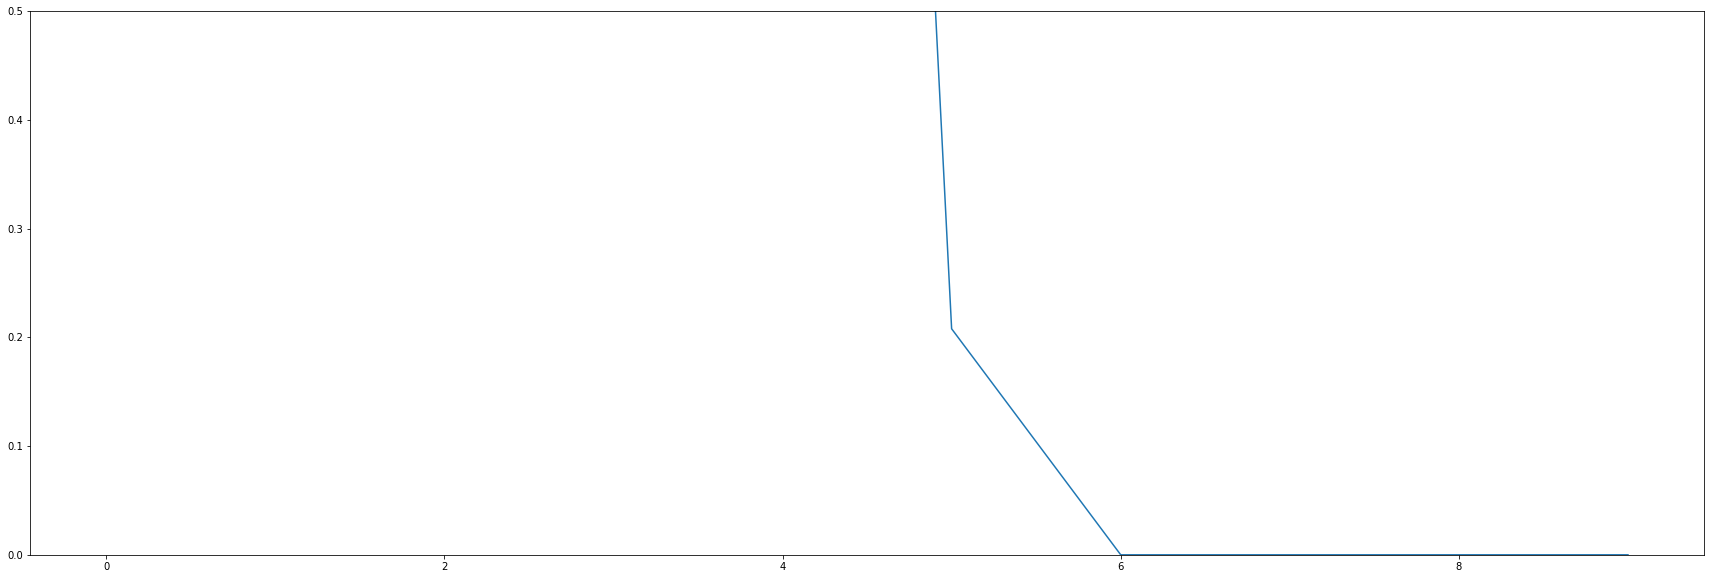

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(range(len(loss_history)), loss_history)
plt.ylim([0,0.5])
plt.show()

In [ ]:
loss_history

This needs a lot of improvement but is a good starting point.

In [ ]:
pred_boxes[0,1]

In [ ]:
pred_boxes[0][2] - gt[0][2]